# WGAN



In [1]:
import os
import tensorflow
from tensorflow.keras.layers import Conv2DTranspose,BatchNormalization
from tensorflow.keras.layers import Input,LeakyReLU,Conv2D,Flatten,Dense,Activation,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np

In [3]:
os.chdir('C:/Users/feher/Documents/Data_Projects/GAN/')
from gan import WGAN, wasserstein_loss

In [4]:
genSize = (100,)

In [5]:
def buildDisc():
    '''Buid the discriminator'''
    input_shape = (28, 28, 1)
    inputs = Input(shape=input_shape, name='discriminator_input')
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]
    x = inputs
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(x)

    x = Flatten()(x)
    x = Dense(1,activation='linear')(x)

    return Model(inputs, x, name='discriminator')

discriminator = buildDisc()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)       

In [6]:
def buildGen():
    '''Build the generator'''
    image_resize = 7
    # network parameters
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]
    
    inputs = Input(shape=genSize,name='generator_input')
    x = inputs

    x = Dense(image_resize * image_resize * layer_filters[0])(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,strides=strides,padding='same')(x)

    x = Activation('sigmoid')(x)
    return Model(inputs, x, name='generator')

generator = buildGen()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
activation (Activation)      (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       51

In [8]:
gan = WGAN(generator=generator,discriminator=discriminator,DiscrOptimizer=RMSprop(lr=5e-5),GanOptimizer=RMSprop(lr=5e-5))

In [9]:
gan.generateBatchEval()

In [10]:
import matplotlib.pyplot as plt
def viewMinst(mtr,ep=None,save=True):
    """view minst"""
    path = "D:/Project/DeepLearning/GAN/WGAN/ouput/Epoch_{}".format(ep)
    title = "Epoch : {}".format(ep)
    
    mtr2 = np.clip(mtr * 255,0,255).astype('uint8')
    plt.imshow(mtr2.reshape(28,28), cmap='gray')
    
    if ep != None:
        if not os.path.isdir(path):
            os.mkdir(path)
        #plt.title(title)
    if save == True and ep != None:
        i = 0
        while os.path.exists(path + '/Epoch{}_{}.jpg'.format(ep,i)):
            i+=1
        plt.savefig(path + '/Epoch{}_{}.jpg'.format(ep,i))

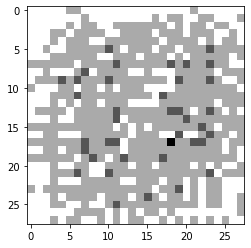

In [11]:
gan.GenerateOutputs(batchSize=16,viewFunction=viewMinst,returnArray=False,ep=0)

In [12]:
from tensorflow.keras.datasets import mnist
(xtr,_),_ = mnist.load_data()
xtr = xtr.reshape((-1,28,28,1)).astype('float32')/255

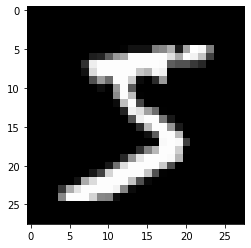

In [13]:
viewMinst(xtr[0],ep=None,save=False)

In [14]:
gan.train(x_train = xtr,batch_size = 1024,epoch = 301,outputTr = viewMinst,evalStep = 10,n_critic = 5,clip_value = 0.01)

Epoch 1/301
 2/11 [====>.........................] - ETA: 56s 

KeyboardInterrupt: 

In [ ]:
gan.GenerateOutputs(batchSize=1,viewFunction=viewMinst,returnArray=False)

In [ ]:
gan.saveGan("D:/Project/DeepLearning/GAN/WGAN/save")